James Gardner and S. Borhanian, 2022 
#### based on quick_start.ipynb by Borhanian 

want to analyse science case/s for CE only:

CE-N 40km with CE-S 40km or 20km

if done, then look at CE-S with one ET detector

In [1]:
from gwbench import network

import os, sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# https://stackoverflow.com/a/45669280; use as ``with HiddenPrints():''
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Network initialisation

In [ ]:
# initialisation is '<config>_<site>'
# other configurations (Tab.4): aLIGO,A+,V+,K+,Voyager-CBO,Voyager-PMO,ET 
# CE configs: <stage>-<arm length>-<optimisation> = CE1/CE2-10/20/30/40-CBO/PMO
# sites/locations (Tab.3): H,L,V,K,I,E,C,N,S; the latter three are Main, North, and South for CE

# choose the desired detectors
# CE-N 40km, CE-S 40km:
network_spec = ['CE1-40-CBO_C', 'CE1-40-CBO_S']
# network_spec = ['CE2-40-CBO_C', 'CE2-40-CBO_S'] # 2nd stage of development, compare as well
# # CE-N 40km, CE-S 20km:
# network_spec = ['CE1-40-CBO_C', 'CE1-20-PMO_S']
# network_spec = ['CE2-40-CBO_C', 'CE2-20-PMO_S'] # 2nd stage

# initialize the network with the desired detectors
net = network.Network(network_spec)

# frequency range
f = np.arange(5., 61.5, 2**-4) # i.e. looking for CBCs around 50 Hz, change for PMO

# choose the desired waveform 
wf_model_name = 'tf2' # TaylorF2, coded in gwbench, allows for symbolic differentiation
# other waveforms are available (e.g. tf2_tidal) but require different injection parameters

# pass the chosen waveform to the network for initialization
net.set_wf_vars(wf_model_name=wf_model_name)

# injection parameters
# for GW150914
inj_params = {
    'Mc':    30.9,
    'eta':   0.247,
    'chi1z': 0,
    'chi2z': 0,
    'DL':    475,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/4,
    'ra':    np.pi/4,
    'dec':   np.pi/4,
    'psi':   np.pi/4,
    'gmst0': 0
    }

# assign with respect to which parameters to take derivatives, for the FIM
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'

# assign which parameters to convert to cos or log versions
conv_cos = ('iota','dec')
conv_log = ('Mc','DL')

# choose whether to take Earth's rotation into account
use_rot = 0

# pass all these variables to the network
net.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
print('Network initialised')

## GW benchmarking

In [ ]:
# compute the WF polarizations and their derivatives
net.calc_wf_polarizations()
net.calc_wf_polarizations_derivs_num()

# setup antenna patterns, location phase factors, and PSDs
net.setup_ant_pat_lpf_psds()
# results are accessed like this
# net.detectors[0].Fp # [i] for ith detector in network
# net.detectors[0].Fc # --> not frequency dependent?
# net.detectors[0].Flp
# net.detectors[0].psd # f in future calculations truncated to match psd

# compute the detector responses and their derivatives
# analogous to WF calculation
net.calc_det_responses()
net.calc_det_responses_derivs_num()
# access results via
# net.detectors[0].hf
# net.detectors[0].del_hf

# calculate the network and detector SNRs
net.calc_snrs()
# print(net.snr, net.snr_sq, net.detectors[0].snr, net.detectors[0].snr_sq)

# calculate the network and detector Fisher matrices, condition numbers, ...
# ... covariance matrices, error estimates, and inversion errors
net.calc_errors() # finds FIMs, then inverts to find covariance matrix and error estimates of params
# print(net.fisher, net.cond_num, net.cov, net.errs, net.inv_err)
# print(net.detectors[0].fisher, net.detectors[0].cond_num, net.detectors[0].cov,
#       net.detectors[0].errs, net.detectors[0].inv_err)

# calculate the 90%-credible sky area (in [deg]^2)
net.calc_sky_area_90()
print('\nBenchmarking complete')

In [ ]:
# print the contents of the detector objects (inside the network)
net.print_detectors()

# print the contents of the network objects
net.print_network()

In [ ]:
# net.get_snrs_errs_cov_fisher_inv_err_for_key(key='network')

In [ ]:
# # check if f truncated in any of the detectors to fit the psd
# for i in range(len(net.detectors)):
#     print(np.all(net.f == net.detectors[i].f))

### replicating Fig 3 from Borhanian 2021 to test understanding, then try for CE only

In [3]:
# try for GW170817 and tf2, then for tf2_tidal

# assume that aLIGO was used
net = network.Network(['aLIGO_H','aLIGO_L','aLIGO_V'])

# not stated, using one from GW170817 paper
# start with 100 sample points, then move up from there (e.g. to 1e4)
fmin, fmax, fnum = 30, 2048, 100
f = np.linspace(fmin, fmax, fnum)

net.set_wf_vars(wf_model_name='tf2_tidal')

# injection parameters for GW170817, reported median values (source-frame)
# using low-spin priors (Borhanian doesn't say which they used)
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.119.161101
# subsequent work (2019) has refined these values
base_measured_params = {
    'Mc':    1.188, # Msun
    'eta':   0.2485, # m1=1.48 Msun, m2=1.265 Msun, m2/m1=0.85, Mtot=2.74 Msun, eta=m1*m2/(m1+m2)**2
    'chi1z': 0,
    'chi2z': 0,
    'DL':    40, # MPc
    'tc':    0, # not quoted
    'phic':  0,
#     'iota':  np.pi/4, # 1000 random instances of these, measured: 55deg
#     'ra':    np.pi/4, # 1000 random instances of these
#     'dec':   np.pi/4, # 1000 random instances of these
    'psi':   np.pi/4, # not quoted, to-do: check effect
    'gmst0': 0, # not quoted but doesn't matter?
    'lam_t': 800, # combined dimensionless tidal deformability
    'delta_lam_t': 0 # not quoted, but assuming zero because distributed around zero
}

# assign with respect to which parameters to take derivatives, for the FIM, all 12 but not delta_lam_t (or gmst0)
deriv_symbs_string = 'Mc eta chi1z chi2z DL tc phic iota ra dec psi lam_t'

# assign which parameters to convert to log or cos versions for differentiation
conv_log = ('Mc', 'DL', 'lam_t')
conv_cos = ('iota', 'dec')

# choose whether to take Earth's rotation into account
use_rot = 0

In [4]:
# starting with just 10 instances, scale up to 1000 later
num_instances = 10

# arrays to store integrated SNR, 1sigma error estimates (for Mc and DL), and 90% credible sky area
results_snr_errs_skyarea = np.empty((num_instances, 4))

with tqdm(total=num_instances) as pbar:
    i = 0
    while i < num_instances:
        # randomly sample inclination and sky position
        iota, ra, dec = np.random.uniform(low=0, high=2*np.pi, size=3)
        inj_params = dict(**base_measured_params, iota=iota, ra=ra, dec=dec)

        # pass all these variables to the network
        net.set_net_vars(
            f=f, inj_params=inj_params,
            deriv_symbs_string=deriv_symbs_string,
            conv_cos=conv_cos, conv_log=conv_log,
            use_rot=use_rot
        )

        with HiddenPrints():
            # compute the WF polarizations and their derivatives
            net.calc_wf_polarizations()
            net.calc_wf_polarizations_derivs_num()

            # setup antenna patterns, location phase factors, and PSDs
            net.setup_ant_pat_lpf_psds()

            # compute the detector responses and their derivatives
            net.calc_det_responses()
            net.calc_det_responses_derivs_num()

            # calculate the network and detector SNRs
            net.calc_snrs()

            # calculate the Fisher and covariance matrices, then error estimates
            net.calc_errors()

            # calculate the 90%-credible sky area (in [deg]^2)
            net.calc_sky_area_90()

        if net.cond_num < 1e15:
            results_snr_errs_skyarea[i] = net.snr, net.errs['log_Mc'], net.errs['log_DL'], net.errs['sky_area_90']
            i += 1
            pbar.update(1)   
            # else, try again until results array full (don't increment index i)           

100%|████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.45s/it]


In [5]:
print(results_snr_errs_skyarea)

[[8.85541746e+01 9.36151637e-04 5.64408901e-01 1.51185901e-01]
 [6.50267213e+01 1.27449230e-03 9.91909424e-01 2.81288106e+00]
 [1.57626605e+01 5.26171935e-03 1.35491823e-01 1.21817558e+01]
 [5.29687772e+01 1.56500677e-03 1.24936273e-01 1.86926956e+00]
 [4.99950539e+01 1.65831207e-03 7.66348444e-02 9.22093336e-01]
 [6.72199559e+01 1.23256689e-03 9.77128139e-02 5.04453308e-01]
 [3.01912044e+01 2.74662914e-03 3.75478490e-02 4.39875052e+00]
 [7.56932126e+01 1.09571280e-03 7.99227073e-01 3.95884015e-01]
 [6.42615705e+01 1.28910702e-03 9.89432511e-02 2.92897045e-01]
 [7.91575279e+01 1.04678854e-03 7.90937163e-01 3.46957729e-01]]


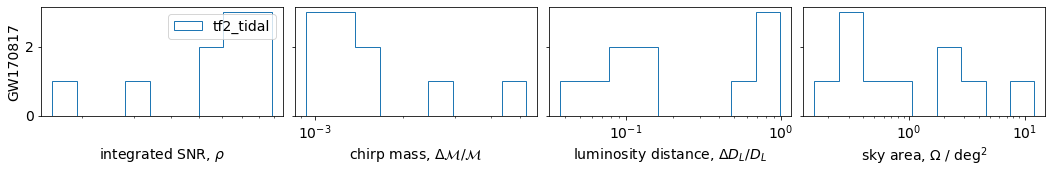

In [65]:
# plotting
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1, 4, figsize=(18, 2), sharey=True, gridspec_kw={'wspace':0.05, 'hspace':0})

for i, ax in enumerate(axs):
    data = results_snr_errs_skyarea[:,i]
    ax.hist(data, histtype='step', facecolor='b', label='tf2_tidal',
            bins=np.geomspace(data.min(), data.max(), num_instances))
    ax.set_xscale('log')
    # to-do: fix the bug that, when there's no major tick, the axis has no reference value
    ax.xaxis.set_minor_locator(plt.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

axs[0].set_ylabel(r'GW170817')
axs[0].set_xlabel(r'integrated SNR, $\rho$')
# error in log(X) is the fractional error in X (i.e. deltaX/X) by chain rule 
axs[1].set_xlabel(r'chirp mass, $\Delta\mathcal{M}/\mathcal{M}$')
axs[2].set_xlabel(r'luminosity distance, $\Delta D_L/D_L$')
axs[3].set_xlabel(r'sky area, $\Omega$ / $\mathrm{deg}^2$')
axs[0].legend()

fig.align_labels()
plt.show(fig)

In [ ]:
# # to-do: "Besides, in order to allow for an
# easier comparison with the measured values we converted the
# fractional errors from the standard 1σ-output of the FIF to the
# respective 90% credible bounds."?